In [ ]:
 !nvidia-smi

Sun Feb 21 09:29:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd "/content/gdrive/My Drive/Colab Notebooks"

/content/gdrive/My Drive/Colab Notebooks


DataLoader

In [ ]:
from os import listdir
from os.path import join

from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize, Grayscale

import random
import math
from torch.autograd import Variable
import torch

import torchvision.transforms as transforms

# gray = transforms.Gray()
import numpy as np

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', 'bmp', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, blocksize):
    return crop_size - (crop_size % blocksize)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop((crop_size,crop_size)),
        RandomHorizontalFlip(p=0.5),
        RandomVerticalFlip(p=0.5),
        # Grayscale(),
        ToTensor(),
    ])



def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse < 1.0e-10:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX/math.sqrt(mse))


class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, blocksize):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, blocksize)
        self.hr_transform = train_hr_transform(crop_size)

    def __getitem__(self, index):
        try:
            hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
            return hr_image, hr_image
        except:
            hr_image = self.hr_transform(Image.open(self.image_filenames[index+1]))
            return hr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)


class TestDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, blocksize, crop_size=96):
        super(TestDatasetFromFolder, self).__init__()
        self.blocksize = blocksize
        self.high_res_length = crop_size
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        self.test_compose = Compose([
            CenterCrop(crop_size),
            # Grayscale(),
            ToTensor(),
            # transforms.Normalize(mean=0.5, std=0.5)
        ])

    def __getitem__(self, index):
        hr_image = Image.open(self.image_filenames[index])

        hr_image = self.test_compose(hr_image)
            
        return hr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)



二值化

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

# ********************* 二值(+-1) ***********************
# A
class Binary_a(Function):

    @staticmethod
    def forward(self, input):
        self.save_for_backward(input)
        output = torch.sign(input)
        return output

    @staticmethod
    def backward(self, grad_output):
        input, = self.saved_tensors
        #*******************ste*********************
        grad_input = grad_output.clone()
        #****************saturate_ste***************
        grad_input[input.ge(1)] = 0
        grad_input[input.le(-1)] = 0
        '''
        #******************soft_ste*****************
        size = input.size()
        zeros = torch.zeros(size).cuda()
        grad = torch.max(zeros, 1 - torch.abs(input))
        #print(grad)
        grad_input = grad_output * grad
        '''
        return grad_input
# W
class Binary_w(Function):

    @staticmethod
    def forward(self, input):
        output = torch.sign(input)
        return output

    @staticmethod
    def backward(self, grad_output):
        #*******************ste*********************
        grad_input = grad_output.clone()
        return grad_input
# ********************* 三值(+-1、0) ***********************
class Ternary(Function):

    @staticmethod
    def forward(self, input):
        # **************** channel级 - E(|W|) ****************
        E = torch.mean(torch.abs(input), (3, 2, 1), keepdim=True)
        # **************** 阈值 ****************
        threshold = E * 0.7
        # ************** W —— +-1、0 **************
        output = torch.sign(torch.add(torch.sign(torch.add(input, threshold)),torch.sign(torch.add(input, -threshold))))
        return output, threshold

    @staticmethod
    def backward(self, grad_output, grad_threshold):
        #*******************ste*********************
        grad_input = grad_output.clone()
        return grad_input

# ********************* A(特征)量化(二值) ***********************
class activation_bin(nn.Module):
  def __init__(self, A):
    super().__init__()
    self.A = A
    self.relu = nn.ReLU(inplace=True)

  def binary(self, input):
    output = Binary_a.apply(input)
    return output

  def forward(self, input):
    if self.A == 2:
      output = self.binary(input)
      # ******************** A —— 1、0 *********************
      #a = torch.clamp(a, min=0)
    else:
      output = self.relu(input)
    return output
# ********************* W(模型参数)量化(三/二值) ***********************
def meancenter_clampConvParams(w):
    mean = w.data.mean(1, keepdim=True)
    w.data.sub(mean) # W中心化(C方向)
    w.data.clamp(-1.0, 1.0) # W截断
    return w
class weight_tnn_bin(nn.Module):
  def __init__(self, W):
    super().__init__()
    self.W = W

  def binary(self, input):
    output = Binary_w.apply(input)
    return output

  def ternary(self, input):
    output = Ternary.apply(input)
    return output

  def forward(self, input):
    if self.W == 2 or self.W == 3:
        # **************************************** W二值 *****************************************
        if self.W == 2:
            output = meancenter_clampConvParams(input) # W中心化+截断
            # **************** channel级 - E(|W|) ****************
            E = torch.mean(torch.abs(output), (3, 2, 1), keepdim=True)
            # **************** α(缩放因子) ****************
            alpha = E
            # ************** W —— +-1 **************
            output = self.binary(output)
            # ************** W * α **************
            output = output * alpha # 若不需要α(缩放因子)，注释掉即可
            # **************************************** W三值 *****************************************
        elif self.W == 3:
            output_fp = input.clone()
            # ************** W —— +-1、0 **************
            output, threshold = self.ternary(input)
            # **************** α(缩放因子) ****************
            output_abs = torch.abs(output_fp)
            mask_le = output_abs.le(threshold)
            mask_gt = output_abs.gt(threshold)
            output_abs[mask_le] = 0
            output_abs_th = output_abs.clone()
            output_abs_th_sum = torch.sum(output_abs_th, (3, 2, 1), keepdim=True)
            mask_gt_sum = torch.sum(mask_gt, (3, 2, 1), keepdim=True).float()
            alpha = output_abs_th_sum / mask_gt_sum # α(缩放因子)
            # *************** W * α ****************
            # output = output * alpha # 若不需要α(缩放因子)，注释掉即可
    else:
      output = input
    return output

# ********************* 量化卷积（同时量化A/W，并做卷积） ***********************
class Conv2d_Q(nn.Conv2d):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=False,
        A=2,
        W=3
      ):
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias
        )
        # 实例化调用A和W量化器
        # self.activation_quantizer = activation_bin(A=A)
        self.weight_quantizer = weight_tnn_bin(W=W)
        self.mask_flag = False
          
    def forward(self, input):
        # 量化A和W
        # bin_input = self.activation_quantizer(input)
        tnn_bin_weight = self.weight_quantizer(self.weight)    
        #print(bin_input)
        if self.mask_flag:
            tnn_bin_weight = tnn_bin_weight * self.mask

        # print(tnn_bin_weight[0][0][0][:])
        # 用量化后的A和W做卷积
        output = F.conv2d(
            input=input, 
            weight=tnn_bin_weight, 
            bias=self.bias, 
            stride=self.stride, 
            padding=self.padding, 
            dilation=self.dilation, 
            groups=self.groups)
        return output

    def set_mask(self, mask):
        self.mask = mask
        # self.weight.data = self.weight.data * self.mask.data
        self.mask_flag = True

    def get_mask(self):
        print(self.mask_flag)
        return self.mask

Attention Layer

In [ ]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c,)
        return y

class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_dim, activation, blocksize=32):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        self.blocksize = blocksize

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
        # #bug聚集地
        # self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # self.linear = nn.Linear(in_features=in_dim, out_features=in_dim*blocksize*blocksize,bias=True)
        # #end 
        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N)
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)

        out = self.gamma*out + x
        '''bug聚集地'''
        # atten = self.avg_pool(out).view(m_batchsize,C)
        # atten = self.linear(atten)
        # atten = atten.view(m_batchsize, C, self.blocksize, self.blocksize)
        return out  # B * C * blocksize * blocksize

In [ ]:

class csPart(nn.Module):
    def __init__(self, blocksize=32, subrate=0.2, channel=1):
        super(csPart, self).__init__()
        #sampling
        # self.sampling = Conv2d_Q(
        #     in_channels=channel, 
        #     out_channels=int(np.round(blocksize*blocksize*subrate*channel)), 
        #     kernel_size=blocksize, 
        #     stride=blocksize, 
        #     padding=0, 
        #     bias=False, 
        #     W=2)
        self.sampling = nn.Conv2d(
            in_channels=channel, 
            out_channels=int(np.round(blocksize*blocksize*subrate*channel)), 
            kernel_size=blocksize, 
            stride=blocksize, 
            padding=0, 
            bias=False,
            )
        self.gamma = nn.Parameter(torch.zeros(1))
        # self.gamma.data[0] = -0.5
        # self.atten = SELayer(channel=int(np.round(blocksize*blocksize*subrate*channel), reduction=16))
        self.atten = Self_Attn(in_dim=int(np.round(blocksize*blocksize*subrate*channel)), activation=False, blocksize=blocksize) #SELayer(channel=int(np.round(blocksize*blocksize*subrate*channel)), reduction=16)
        # self.sampling = nn.Conv2d(1, int(np.round(blocksize*blocksize*subrate)), blocksize, stride=blocksize, padding=0, bias=False)
        #init reconstruction
        self.upsampling = nn.Conv2d(int(np.round(blocksize*blocksize*subrate*channel)), blocksize*blocksize*channel, 1, stride=1, padding=0)
        # self.upsampling = nn.Sequential(
        #     nn.Conv2d(int(np.round(blocksize*blocksize*subrate*channel)), blocksize*blocksize, 1, stride=1, padding=0, bias=True),
        #     nn.LeakyReLU()
        # )
        
        self.dwc = nn.Sequential(
            nn.Conv2d(in_channels=blocksize * blocksize*channel,
                      out_channels=blocksize * blocksize*channel,
                      kernel_size=1, stride=1, padding=0,
                      groups=blocksize * blocksize),
            # nn.LeakyReLU(),
            nn.Conv2d(in_channels=blocksize * blocksize*channel, out_channels=blocksize*blocksize*channel, kernel_size=1, padding=0),
            # nn.LeakyReLU()
        )
        # self.activation = nn.LeakyReLU()

    def forward(self, input):
        x = self.sampling(input)
        # torch.save(x)
        x = self.gamma * x + x
        atten_matrix = self.atten(x)
        x = self.upsampling(atten_matrix)
        # x = self.activation(x)
        x = self.dwc(x)# + x
        # x = self.activation(x)
        return x

class sconv2d(nn.Module):
    def __init__(self, channels=64, outchannels=64):
        super(sconv2d, self).__init__()
        self.channels = channels
        self.separable_conv2d = nn.Sequential(
            nn.Conv2d(in_channels=channels,
                      out_channels=channels,
                      kernel_size=(1, 1), stride=1, padding=0,
                      groups=channels),
            nn.Conv2d(in_channels=channels, out_channels=outchannels, kernel_size=(1, 1), padding=0),
            # nn.LeakyReLU()
        )
        # self.relu = nn.LeakyReLU()
    
    def forward(self, input):
        x = self.separable_conv2d(input)
        # x = self.relu(x)
        return x


class baseblock(nn.Module):
    def __init__(self, channels=64):
        super(baseblock, self).__init__()
        
        self.conv1 = nn.Sequential(
            # nn.Conv2d(channels, channels, kernel_size=(3, 3), stride=1, padding=1, bias=True),
            sconv2d(channels=channels),
            nn.LeakyReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            # nn.Conv2d(channels, channels, kernel_size=(3, 3), stride=1, padding=1, bias=True),
            sconv2d(channels=channels),
            nn.LeakyReLU(inplace=True)
        )
        # self.relu = nn.LeakyReLU()
    def forward(self, input):
        # x = self.relu(input)
        x = self.conv1(input)
        x = x + input
        x = self.conv2(x)
        return x


class DenseBlock(nn.Module):
    def __init__(self, conv_in, conv_out, k_size, beta=0.2):
        super(DenseBlock, self).__init__()

        self.res1 = nn.Sequential(
            # nn.Conv2d(conv_in, conv_out, kernel_size=(k_size, k_size), stride=1, padding=1),
            sconv2d(channels=conv_in, outchannels=conv_out),
            nn.LeakyReLU(inplace=True)
        )

        self.res2 = nn.Sequential(
            # nn.Conv2d(conv_in*2, conv_out, kernel_size=(k_size, k_size), stride=1, padding=1),
            sconv2d(channels=conv_in*2, outchannels=conv_out),
            nn.LeakyReLU(inplace=True)
        )

        self.res3 = nn.Sequential(
            # nn.Conv2d(conv_in*3, conv_out, kernel_size=(k_size, k_size), stride=1, padding=1),
            sconv2d(channels=conv_in*3, outchannels=conv_out),
            # nn.LeakyReLU(inplace=True)
        )

        # self.res4 = nn.Sequential(
            # nn.Conv2d(conv_in*4, conv_out, kernel_size=(k_size, k_size), stride=1, padding=1),
            # sconv2d(channels=conv_in*4, outchannels=conv_out),
            # nn.LeakyReLU(inplace=True),
        # )

        # self.res5 = nn.Sequential(
        #     nn.Conv2d(conv_in*5, conv_out, kernel_size=(k_size, k_size), stride=1, padding=1),
        #     sconv2d(channels=conv_in*3, outchannels=conv_out),
        # )
        self.beta = beta

    def forward(self, input):
        x = input
        #feature size = convin*2
        result = self.res1(x)
        x = torch.cat([x, result], 1)

        result = self.res2(x)
        # print(x.shape,result.shape)
        x = torch.cat([x, result], 1)
        

        x = self.res3(x)
        # x = torch.cat([x, result], 1)

        # x = self.res4(x)
        # x = torch.cat([x, result], 1)

        # x = self.res5(x)

        output = x.mul(self.beta)
        return output + input

class ResidualInResidualDenseBlock(nn.Module):
    def __init__(self, conv_in=64, k_size=3, beta=0.2):
        super(ResidualInResidualDenseBlock, self).__init__()

        self.dense1 = DenseBlock(conv_in, conv_in, k_size)
        self.dense2 = DenseBlock(conv_in, conv_in, k_size)
        self.dense3 = DenseBlock(conv_in, conv_in, k_size)
        self.beta = beta

    def forward(self, input):
        x = self.dense1(input)
        x = self.dense2(x)
        x = self.dense3(x)
        output = x.mul(self.beta)
        return output + input



In [ ]:
class CSNetPlus(nn.Module):
    def __init__(self,blocksize=32, subrate=0.2, channels=1):
        super(CSNetPlus, self).__init__()
        self.blocksize = blocksize
        self.subrate = subrate
        self.channels = channels
        n_baseblock = 10
        outchannels = 64

        self.csPart = csPart(blocksize, subrate, channels)
        self.rrdb = ResidualInResidualDenseBlock(conv_in=outchannels, k_size=3,)
        self.reshape = nn.PixelShuffle(upscale_factor=self.blocksize)
        self.dalconv = nn.Sequential(
                    nn.Conv2d(in_channels=outchannels,
                        out_channels=outchannels,
                        kernel_size=(3, 3),
                        stride=1,
                        padding=2,
                        dilation=2,
                        bias=True),
                    nn.LeakyReLU(inplace=True))

        self.dr1 = nn.Sequential(
            nn.Conv2d(channels, outchannels, kernel_size=(3, 3), stride=1, padding=1, bias=True),
            nn.LeakyReLU(inplace=True)
        )
        baseblock_layers = []
        for i in range(n_baseblock):
            if( i%2 == 1):
                baseblock_layers.append(nn.Sequential(
                    nn.Conv2d(in_channels=outchannels,
                        out_channels=outchannels,
                        kernel_size=(3, 3),
                        stride=1,
                        padding=2,
                        dilation=2,
                        bias=True),
                    nn.LeakyReLU(inplace=True)))
                
            # baseblock_layers.append(ResidualInResidualDenseBlock(conv_in=outchannels, k_size=3,))
            baseblock_layers.append(DenseBlock(conv_in=outchannels, conv_out=outchannels, k_size=3, beta=0.3))
            
        self.baseblock_seq = nn.Sequential(*baseblock_layers)

        self.out_conv = nn.Conv2d(outchannels, channels, kernel_size=(3, 3), stride=1, padding=1, bias=True)
        

    def forward(self, input):
        x = self.csPart(input)
        # x = self.rrdb(x)
        reshape = self.reshape(x)
        dr1 = self.dr1(reshape)
        # x = self.rrdb(dr1)
        # x = self.rrdb(x)
        x = self.baseblock_seq(dr1)
        x = self.out_conv(x)
        x = x + reshape
        return x, reshape



In [ ]:
!pip install pytorch-msssim
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

剪枝使用的代码

In [ ]:
"""参数化，区别是否需要反向传播更新"""
def to_var(x, requires_grad=False, volatile=False):
    """
    Varialbe type that automatically choose cpu or cuda
    """
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad, volatile=volatile)

#计算峰值信噪比
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)


#计算掩码以用于 对权重矩阵进行做哈达玛积，进而实现三值化
#要不要abs？ No
#cal_mask()
def atten_cal_mask(atten_matrix, origin_matrix, pruning_perc):
    print("=========>calculate mask")
    masks = []
    campare_matrix = atten_matrix.cpu() - origin_matrix.cpu()
    atten_cal_weights = list(campare_matrix.cpu().data.numpy().flatten())
    origin_weights = list(origin_matrix.cpu().data.abs().numpy().flatten())
    threshold_weight = np.percentile(np.array(origin_weights), 70)
    threshold_atten = np.percentile(np.array(atten_cal_weights), pruning_perc)
    data_len = len(atten_cal_weights)
    count = 0
    for i in range(data_len):
        prun_val = 1
        if origin_weights[i] < threshold_weight and atten_cal_weights[i] < threshold_atten:
            prun_val = 0
            count += 1
        masks.append(prun_val)
    print("true cut rate:", count / data_len)
    masks = torch.tensor(masks)
    masks = to_var(masks)
    masks = masks.view(origin_matrix.size())
    print("=========>mask calculate finish")
    return masks

#计算掩码以用于 对权重矩阵进行做哈达玛积，进而实现三值化
#要不要abs？ No
#atten_cal_mask(atten_matrix=torch.load("path")["atten_matrix"], origin_matrix=model.csPart.sampling.weight, pruning_perc=0.3)
def atten_cal_mask(atten_matrix, origin_matrix, pruning_perc):
    print("=========>calculate mask")
    masks = []
    campare_matrix = atten_matrix.cpu() - origin_matrix.cpu()
    all_weights = list(campare_matrix.cpu().data.numpy().flatten())
    threshold = np.percentile(np.array(all_weights), pruning_perc)
    for atten in all_weights:
        prun_val = 0
        if atten.data > threshold:
            prun_val = 1
        masks.append(prun_val)

    masks = torch.tensor(masks)
    masks = to_var(masks)
    masks = masks.view(origin_matrix.size())
    print("=========>mask calculate finish")
    return masks

#为三值化载入权重Attention矩阵时使用
class targetPart(nn.Module):
    def __init__(self, blocksize=32, subrate=0.3, channel=1):
        super(targetPart, self).__init__()
        self.gamma = nn.Parameter(torch.zeros(1))#torch.Tensor([-0.3960])
        self.real_atten = nn.Conv2d(in_channels=channel, out_channels=int(np.round(blocksize*blocksize*subrate*channel)), kernel_size=blocksize, stride=blocksize, padding=0, bias=False)
    def forward(self, input):
        x = self.real_atten(input)
        x = (self.gamma + 1) * x
        return x

Train

In [ ]:
import argparse, os, heapq
import torch
import torchvision
import math, random
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from torchvision import models
import torch.utils.model_zoo as model_zoo
import matplotlib.pyplot as plt
from PIL import Image


# Training settings
parser = argparse.ArgumentParser(description="PyTorch SRResNet")
parser.add_argument("--batchSize", type=int, default=32, help="training batch size")
parser.add_argument("--nEpochs", type=int, default=800, help="number of epochs to train for")
parser.add_argument("--lr", type=float, default=1e-4, help="Learning Rate. Default=1e-4")
parser.add_argument("--step", type=int, default=200, help="Sets the learning rate to the initial LR decayed by momentum every n epochs, Default: n=500")
parser.add_argument("--cuda", action="store_true", help="Use cuda?")
parser.add_argument("--resume", default="", type=str, help="Path to checkpoint (default: none)")
parser.add_argument("--start-epoch", default=1, type=int, help="Manual epoch number (useful on restarts)")
parser.add_argument("--threads", type=int, default=4, help="Number of threads for data loader to use, Default: 1")
parser.add_argument("--pretrained", default="", type=str, help="path to pretrained model (default: none)")
parser.add_argument("--vgg_loss", action="store_true", help="Use content loss?")
parser.add_argument("--gpus", default="0", type=str, help="gpu ids (default: 0)")

def main():

    global opt, model, netContent
    input_args = []
    opt = parser.parse_args([])
    # print(opt)
    channel = 3
    opt.vgg_loss = False#True if channel==3 else False
    opt.cuda = True
    # opt.pretrained = "CSNetPlus_model_trgb_full_0.2_800_.pth" 
    opt.pretrained = "/content/checkpoint/model_epoch_464_.pth"#  #
    # opt.pretrained = "saved_models/0.4/full_db3_%3_10_28.98.pth"
    opt.lr = 0.0003
    scheduler_step_size=100
    scheduler_gamma=0.5
    regularization_lambda = 1e-4
    blocksize = 32
    subrate = 0.2
    cuda = opt.cuda
    attention_path = "CSNetPlus_model_mask/0.1_0.0088.pth"
    if cuda:
        print("=> use gpu id: '{}'".format(opt.gpus))
        os.environ["CUDA_VISIBLE_DEVICES"] = opt.gpus
        if not torch.cuda.is_available():
                raise Exception("No GPU found or Wrong gpu id, please run without --cuda")

    opt.seed = random.randint(1, 10000)
    print("Random Seed: ", opt.seed) #5868  3878
    torch.manual_seed(opt.seed)
    if cuda:
        torch.cuda.manual_seed(opt.seed)

    cudnn.benchmark = True

    print("===> Loading datasets")
    # train_set = DatasetFromHdf5("/path/to/your/hdf5/data/like/rgb_srresnet_x4.h5")
    train_data_val2017 = 'dataSet/val2017'
    train_data_rgb_2017 = "dataSet/2017/val2017"
    train_data_train2017 = "dataSet/2017/train2017"
    train_data_BSDS500 = 'dataSet/BSDS500/data/images/train'
    test_data = 'dataSet/Test/Set12/'
    test_data_rgb = "dataSet/datasets/LIVE1/"

    train_path = train_data_BSDS500
    train_set = TrainDatasetFromFolder(train_path, crop_size=96, blocksize=32)
    test_set = TestDatasetFromFolder(test_data_rgb, blocksize=32)
    # train_loader = DataLoader(dataset=train_set, num_workers=4, batch_size=opt.batchSize, shuffle=True)

    training_data_loader = DataLoader(dataset=train_set, num_workers=opt.threads, \
        batch_size=opt.batchSize, shuffle=True)
    testing_data_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=0)

    if opt.vgg_loss:
        print('===> Loading VGG model')
        netVGG = models.vgg19()
        netVGG.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/vgg19-dcbb9e9d.pth'))
        class _content_model(nn.Module):
            def __init__(self):
                super(_content_model, self).__init__()
                self.feature = nn.Sequential(*list(netVGG.features.children())[:-1])
                
            def forward(self, x):
                out = self.feature(x)
                return out

        netContent = _content_model()

    print("===> Building model")
    model = CSNetPlus(blocksize=32, subrate=subrate, channels=channel)
    
    # criterion = nn.MSELoss(size_average=False)
    criterion = nn.L1Loss(size_average=False)
    # criterion = SSIM(win_size=11, win_sigma=1.5, data_range=1, size_average=True, channel=channel)

    print("===> Setting GPU")
    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()
        if opt.vgg_loss:
            netContent = netContent.cuda() 

    # optionally resume from a checkpoint
    if opt.resume:
        if os.path.isfile(opt.resume):
            print("=> loading checkpoint '{}'".format(opt.resume))
            checkpoint = torch.load(opt.resume)
            opt.start_epoch = checkpoint["epoch"] + 1
            model.load_state_dict(checkpoint["model"].state_dict())
        else:
            print("=> no checkpoint found at '{}'".format(opt.resume))

    # optionally copy weights from a checkpoint
    if opt.pretrained:
        if os.path.isfile(opt.pretrained):
            print("=> loading model '{}'".format(opt.pretrained))
            weights = torch.load(opt.pretrained)
            model.load_state_dict(weights['model'].state_dict())
        else:
            print("=> no model found at '{}'".format(opt.pretrained))

    print("===> Setting Optimizer")
    optimizer = optim.Adam(model.parameters(), lr=opt.lr, betas=(0.9, 0.999))
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

    print("===> Training")
    now_min_loss = float('inf')
    max_val_psnr = 20
    global max_psnr_epoch,real_max_val_psnr,heap
    max_psnr_epoch = 0
    real_max_val_psnr = 0
    heap = []
    #计算mask用于三值化
    # mask = atten_cal_mask(atten_matrix=torch.load(attention_path)["atten_matrix"], origin_matrix=model.csPart.sampling.weight, pruning_perc=30)
    # model.csPart.sampling.set_mask(mask)
    
    for epoch in range(opt.start_epoch, opt.nEpochs + 1):
        # epoch_loss = train(training_data_loader, optimizer, scheduler, model, criterion, epoch, testing_data_loader)
        val_psnr = train(training_data_loader, optimizer, scheduler, model, criterion, epoch, testing_data_loader)
        save_checkpoint("/content/checkpoint/", model, epoch ,0)
        if val_psnr > real_max_val_psnr:
            real_max_val_psnr = val_psnr
            max_psnr_epoch = epoch
        if epoch <= 5 :
            heapq.heappush(heap,(val_psnr,epoch))
        elif val_psnr > heapq.nsmallest(1,heap)[0][0]:
            heapq.heapreplace(heap,(val_psnr,epoch))

        # if epoch%5 == 0 and epoch_loss < 1000 and epoch_loss < now_min_loss:
        if epoch%5 == 0 and val_psnr > 35 and val_psnr > max_val_psnr:
            save_checkpoint("/content/gdrive/My Drive/Colab Notebooks/CSNetPlus_model_t/",model,epoch,val_psnr) #epoch_loss
            # now_min_loss = epoch_loss
            max_val_psnr = val_psnr

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10"""
    lr = opt.lr * (0.1 ** (epoch // opt.step))
    return lr 

def train(training_data_loader, optimizer, scheduler, model, criterion, epoch, testing_data_loader):
    
    train_bar = tqdm(training_data_loader)
    running_results = {'batch_sizes': 0, 'loss': 0, }
    # lr = adjust_learning_rate(optimizer, epoch-1)
    # for param_group in optimizer.param_groups:
    #     param_group["lr"] = lr
    model.train()
    scheduler.step()
    # wgt1 = 1 if epoch < 200 else 2
    # wgt2 = 3 - wgt1
    # for iteration, batch in enumerate(training_data_loader, 1):
    for data, target in train_bar:
        batch_size = data.size(0)
        if batch_size <= 0:
            continue

        running_results['batch_sizes'] += batch_size
        real_img = Variable(target)
        if opt.cuda:
            real_img = real_img.cuda()

        z = Variable(data)
        if opt.cuda:
            z = z.cuda()
        fake_img, reshape = model(z)
        #对atten层添加 L0.5 正则化   atten 要单独计算从(模型中return回来---待完成)
        # lhalf_loss = torch.norm(atten, p=0.5)
        loss = criterion(fake_img, real_img)#*wgt1 + criterion(reshape, real_img)*wgt2 #regularization_lambda*lhalf_loss
        # loss = (1 - loss) * 100

        if opt.vgg_loss:
            content_input = netContent(fake_img)
            content_target = netContent(real_img)
            content_target = content_target.detach()
            content_loss = criterion(content_input, content_target)

        optimizer.zero_grad()

        if opt.vgg_loss:
            netContent.zero_grad()
            content_loss.backward(retain_graph=True)

        loss.backward()

        optimizer.step()
        running_results['loss'] += loss.item() * batch_size

        train_bar.set_description(desc='[%d] Loss: %.4f lr: %.7f' % (
            epoch, running_results['loss'] / running_results['batch_sizes'], optimizer.param_groups[0]['lr']))
        
    #val
    val_psnr = 0
    model.eval()
    low_res_sample, high_res_sample = next(iter(testing_data_loader))
    fake_images,_ = model(low_res_sample.cuda())
    fake_images = fake_images.cpu().detach()
    # print(low_res_sample.size(0))
    for idx in range(low_res_sample.size(0)):
        fake_image = fake_images.data[idx].numpy().astype(np.float32)
        fake_image = fake_image*255.
        fake_image[fake_image<0] = 0
        fake_image[fake_image>255.] = 255.
        fake_image = fake_image[0,:,:]

        im_res_y = high_res_sample.data[idx].numpy().astype(np.float32)

        im_res_y = im_res_y*255.
        im_res_y[im_res_y<0] = 0
        im_res_y[im_res_y>255.] = 255. 
        im_res_y = im_res_y[0,:,:]
        psnr = PSNR(im_res_y, fake_image, shave_border=0)
        # print(psnr)
        val_psnr += psnr
    val_psnr /= low_res_sample.size(0)
    print("val_psnr: ",val_psnr)

    # show samples
    # low_res_sample, high_res_sample = next(iter(testing_data_loader))
    # idx = np.random.randint(0, 14, 1)
    # fake_image,_ = model(low_res_sample[idx].cuda())
    # fake_image = fake_image.cpu().detach()
    # ground_truth = high_res_sample[idx]
    # image_grid = torchvision.utils.make_grid([fake_image[0], ground_truth[0]], nrow=2, normalize=True)
    # _, plot = plt.subplots(figsize=(12, 12))
    # plt.axis('off')
    # plot.imshow(image_grid.permute(1, 2, 0))
    # plt.savefig("CSNetPlus_CheckpointImage" + '/epoch_{}_checkpoint.jpg'.format(epoch), bbox_inches='tight')
    # return running_results['loss'] / running_results['batch_sizes']
    return val_psnr 


def save_checkpoint(path, model, epoch, epoch_loss=0):
    model_out_path = path + "model_epoch_{}_{}.pth".format(epoch, "" if epoch_loss==0 else epoch_loss)
    state = {"epoch": epoch ,"model": model}
    if not os.path.exists(path):
        os.makedirs(path)

    torch.save(state, model_out_path)

    print("Checkpoint saved to {}".format(model_out_path))

if __name__ == "__main__":
    main()


val_psnr:  32.75923665696744
Checkpoint saved to /content/checkpoint/model_epoch_459_.pth



val_psnr:  32.74421757512749
Checkpoint saved to /content/checkpoint/model_epoch_460_.pth



val_psnr:  32.77750353330322
Checkpoint saved to /content/checkpoint/model_epoch_461_.pth



val_psnr:  32.79448821437508
Checkpoint saved to /content/checkpoint/model_epoch_462_.pth



val_psnr:  32.764820914926936
Checkpoint saved to /content/checkpoint/model_epoch_463_.pth



val_psnr:  32.744810686145485
Checkpoint saved to /content/checkpoint/model_epoch_464_.pth



val_psnr:  32.757576853658065
Checkpoint saved to /content/checkpoint/model_epoch_465_.pth



val_psnr:  32.79786833333059
Checkpoint saved to /content/checkpoint/model_epoch_466_.pth



val_psnr:  32.78772816344053
Checkpoint saved to /content/checkpoint/model_epoch_467_.pth



val_psnr:  32.75233730733626
Checkpoint saved to /content/checkpoint/model_epoch_468_.pth



val_psnr:  32.75697263989899
Checkpoint saved to /content/checkpoint/model_epoch_469_.pth



val_psnr:  32.772462510742024
Checkpoint saved to /content/checkpoint/model_epoch_470_.pth



val_psnr:  32.780125334355645
Checkpoint saved to /content/checkpoint/model_epoch_471_.pth



val_psnr:  32.736974974442624
Checkpoint saved to /content/checkpoint/model_epoch_472_.pth



val_psnr:  32.77820508141881
Checkpoint saved to /content/checkpoint/model_epoch_473_.pth



val_psnr:  32.74809912728528
Checkpoint saved to /content/checkpoint/model_epoch_474_.pth



val_psnr:  32.742816721687966
Checkpoint saved to /content/checkpoint/model_epoch_475_.pth



val_psnr:  32.77329636325148
Checkpoint saved to /content/checkpoint/model_epoch_476_.pth



val_psnr:  32.796548790271814
Checkpoint saved to /content/checkpoint/model_epoch_477_.pth



val_psnr:  32.76428078907026
Checkpoint saved to /content/checkpoint/model_epoch_478_.pth



val_psnr:  32.740833312718806
Checkpoint saved to /content/checkpoint/model_epoch_479_.pth



val_psnr:  32.74544430910489
Checkpoint saved to /content/checkpoint/model_epoch_480_.pth



val_psnr:  32.719865892746114
Checkpoint saved to /content/checkpoint/model_epoch_481_.pth



val_psnr:  32.77016059317224
Checkpoint saved to /content/checkpoint/model_epoch_482_.pth



val_psnr:  32.7786191198933
Checkpoint saved to /content/checkpoint/model_epoch_483_.pth



val_psnr:  32.8038687515669
Checkpoint saved to /content/checkpoint/model_epoch_484_.pth



val_psnr:  32.78294014062483
Checkpoint saved to /content/checkpoint/model_epoch_485_.pth



val_psnr:  32.79608012909733
Checkpoint saved to /content/checkpoint/model_epoch_486_.pth



val_psnr:  32.75291731933136
Checkpoint saved to /content/checkpoint/model_epoch_487_.pth



val_psnr:  32.79975282022438
Checkpoint saved to /content/checkpoint/model_epoch_488_.pth



val_psnr:  32.784302306860646
Checkpoint saved to /content/checkpoint/model_epoch_489_.pth



val_psnr:  32.8014783605561
Checkpoint saved to /content/checkpoint/model_epoch_490_.pth



val_psnr:  32.81020208365612
Checkpoint saved to /content/checkpoint/model_epoch_491_.pth



val_psnr:  32.791831111439514
Checkpoint saved to /content/checkpoint/model_epoch_492_.pth



val_psnr:  32.74611935451424
Checkpoint saved to /content/checkpoint/model_epoch_493_.pth



val_psnr:  32.745954354496405
Checkpoint saved to /content/checkpoint/model_epoch_494_.pth



val_psnr:  32.79682216149327
Checkpoint saved to /content/checkpoint/model_epoch_495_.pth



val_psnr:  32.771069801955846
Checkpoint saved to /content/checkpoint/model_epoch_496_.pth



val_psnr:  32.80760104489693
Checkpoint saved to /content/checkpoint/model_epoch_497_.pth



val_psnr:  32.812064738206765
Checkpoint saved to /content/checkpoint/model_epoch_498_.pth



val_psnr:  32.810775524941725
Checkpoint saved to /content/checkpoint/model_epoch_499_.pth



val_psnr:  32.883720329467025
Checkpoint saved to /content/checkpoint/model_epoch_500_.pth



val_psnr:  32.90364867008487
Checkpoint saved to /content/checkpoint/model_epoch_501_.pth



val_psnr:  32.91460929059951
Checkpoint saved to /content/checkpoint/model_epoch_502_.pth



val_psnr:  32.92769654809955
Checkpoint saved to /content/checkpoint/model_epoch_503_.pth



val_psnr:  32.93522421584061
Checkpoint saved to /content/checkpoint/model_epoch_504_.pth



val_psnr:  32.92468236991155
Checkpoint saved to /content/checkpoint/model_epoch_505_.pth



val_psnr:  32.93240361160464
Checkpoint saved to /content/checkpoint/model_epoch_506_.pth



val_psnr:  32.91653865197557
Checkpoint saved to /content/checkpoint/model_epoch_507_.pth



val_psnr:  32.91917435295609
Checkpoint saved to /content/checkpoint/model_epoch_508_.pth



val_psnr:  32.93947445594499
Checkpoint saved to /content/checkpoint/model_epoch_509_.pth



val_psnr:  32.937398906673415
Checkpoint saved to /content/checkpoint/model_epoch_510_.pth



val_psnr:  32.932893314589776
Checkpoint saved to /content/checkpoint/model_epoch_511_.pth



val_psnr:  32.92428297679497
Checkpoint saved to /content/checkpoint/model_epoch_512_.pth



val_psnr:  32.935149509677515
Checkpoint saved to /content/checkpoint/model_epoch_513_.pth



val_psnr:  32.942265055828116
Checkpoint saved to /content/checkpoint/model_epoch_514_.pth



val_psnr:  32.91483420832179
Checkpoint saved to /content/checkpoint/model_epoch_515_.pth



val_psnr:  32.93503691696226
Checkpoint saved to /content/checkpoint/model_epoch_516_.pth



val_psnr:  32.94123218488839
Checkpoint saved to /content/checkpoint/model_epoch_517_.pth



val_psnr:  32.93783073674523
Checkpoint saved to /content/checkpoint/model_epoch_518_.pth



val_psnr:  32.91828508208047
Checkpoint saved to /content/checkpoint/model_epoch_519_.pth



val_psnr:  32.9374000831392
Checkpoint saved to /content/checkpoint/model_epoch_520_.pth



val_psnr:  32.936450796173936
Checkpoint saved to /content/checkpoint/model_epoch_521_.pth



val_psnr:  32.927718377367015
Checkpoint saved to /content/checkpoint/model_epoch_522_.pth



val_psnr:  32.93126154704834
Checkpoint saved to /content/checkpoint/model_epoch_523_.pth



val_psnr:  32.93691092509999
Checkpoint saved to /content/checkpoint/model_epoch_524_.pth



val_psnr:  32.94803487925451
Checkpoint saved to /content/checkpoint/model_epoch_525_.pth



val_psnr:  32.94785987085348
Checkpoint saved to /content/checkpoint/model_epoch_526_.pth



val_psnr:  32.93772150606487
Checkpoint saved to /content/checkpoint/model_epoch_527_.pth



val_psnr:  32.951497006111325
Checkpoint saved to /content/checkpoint/model_epoch_528_.pth



val_psnr:  32.94406194758888
Checkpoint saved to /content/checkpoint/model_epoch_529_.pth



val_psnr:  32.94060001475262
Checkpoint saved to /content/checkpoint/model_epoch_530_.pth



val_psnr:  32.939833209763805
Checkpoint saved to /content/checkpoint/model_epoch_531_.pth



val_psnr:  32.950466839111684
Checkpoint saved to /content/checkpoint/model_epoch_532_.pth



val_psnr:  32.943675752543506
Checkpoint saved to /content/checkpoint/model_epoch_533_.pth



val_psnr:  32.95510165271632
Checkpoint saved to /content/checkpoint/model_epoch_534_.pth



val_psnr:  32.94186645880436
Checkpoint saved to /content/checkpoint/model_epoch_535_.pth



val_psnr:  32.962390420219045
Checkpoint saved to /content/checkpoint/model_epoch_536_.pth



val_psnr:  32.94783045209045
Checkpoint saved to /content/checkpoint/model_epoch_537_.pth



val_psnr:  32.95990778774903
Checkpoint saved to /content/checkpoint/model_epoch_538_.pth



val_psnr:  32.94718499481383
Checkpoint saved to /content/checkpoint/model_epoch_539_.pth



val_psnr:  32.940442078798
Checkpoint saved to /content/checkpoint/model_epoch_540_.pth



val_psnr:  32.94362705845865
Checkpoint saved to /content/checkpoint/model_epoch_541_.pth



val_psnr:  32.95414674877345
Checkpoint saved to /content/checkpoint/model_epoch_542_.pth



val_psnr:  32.94321880575853
Checkpoint saved to /content/checkpoint/model_epoch_543_.pth



val_psnr:  32.96382618778835
Checkpoint saved to /content/checkpoint/model_epoch_544_.pth



val_psnr:  32.96197450120137
Checkpoint saved to /content/checkpoint/model_epoch_545_.pth



val_psnr:  32.941400873439385
Checkpoint saved to /content/checkpoint/model_epoch_546_.pth



val_psnr:  32.95283772183922
Checkpoint saved to /content/checkpoint/model_epoch_547_.pth



val_psnr:  32.941747936699684
Checkpoint saved to /content/checkpoint/model_epoch_548_.pth



val_psnr:  32.94503532052208
Checkpoint saved to /content/checkpoint/model_epoch_549_.pth



val_psnr:  32.952232873729535
Checkpoint saved to /content/checkpoint/model_epoch_550_.pth



val_psnr:  32.95812060539644
Checkpoint saved to /content/checkpoint/model_epoch_551_.pth



val_psnr:  32.95103429212598
Checkpoint saved to /content/checkpoint/model_epoch_552_.pth



val_psnr:  32.95549115392735
Checkpoint saved to /content/checkpoint/model_epoch_553_.pth



val_psnr:  32.95951142328121
Checkpoint saved to /content/checkpoint/model_epoch_554_.pth



val_psnr:  32.97706191211138
Checkpoint saved to /content/checkpoint/model_epoch_555_.pth



val_psnr:  32.9712443546904
Checkpoint saved to /content/checkpoint/model_epoch_556_.pth



val_psnr:  32.96569115628235
Checkpoint saved to /content/checkpoint/model_epoch_557_.pth



val_psnr:  32.972545187786025
Checkpoint saved to /content/checkpoint/model_epoch_558_.pth



val_psnr:  32.981514142372454
Checkpoint saved to /content/checkpoint/model_epoch_559_.pth



val_psnr:  32.97914321787318
Checkpoint saved to /content/checkpoint/model_epoch_560_.pth



val_psnr:  32.96161083439419
Checkpoint saved to /content/checkpoint/model_epoch_561_.pth



val_psnr:  32.97586356318007
Checkpoint saved to /content/checkpoint/model_epoch_562_.pth



val_psnr:  32.955475327343734
Checkpoint saved to /content/checkpoint/model_epoch_563_.pth



val_psnr:  32.96825227790691
Checkpoint saved to /content/checkpoint/model_epoch_564_.pth



val_psnr:  32.98353059734052
Checkpoint saved to /content/checkpoint/model_epoch_565_.pth



val_psnr:  32.97230285534029
Checkpoint saved to /content/checkpoint/model_epoch_566_.pth



val_psnr:  32.98211488158809
Checkpoint saved to /content/checkpoint/model_epoch_567_.pth



val_psnr:  32.97631748358084
Checkpoint saved to /content/checkpoint/model_epoch_568_.pth



val_psnr:  32.96619973875638
Checkpoint saved to /content/checkpoint/model_epoch_569_.pth



val_psnr:  32.943588997566536
Checkpoint saved to /content/checkpoint/model_epoch_570_.pth



val_psnr:  32.9588873003175
Checkpoint saved to /content/checkpoint/model_epoch_571_.pth



val_psnr:  32.97474229774099
Checkpoint saved to /content/checkpoint/model_epoch_572_.pth



val_psnr:  32.9726469796869
Checkpoint saved to /content/checkpoint/model_epoch_573_.pth



val_psnr:  32.98485139460897
Checkpoint saved to /content/checkpoint/model_epoch_574_.pth



val_psnr:  32.97789387692529
Checkpoint saved to /content/checkpoint/model_epoch_575_.pth



val_psnr:  32.97874682349949
Checkpoint saved to /content/checkpoint/model_epoch_576_.pth



val_psnr:  32.993012756740946
Checkpoint saved to /content/checkpoint/model_epoch_577_.pth



val_psnr:  32.968994434886326
Checkpoint saved to /content/checkpoint/model_epoch_578_.pth



val_psnr:  32.990056754166
Checkpoint saved to /content/checkpoint/model_epoch_579_.pth



val_psnr:  32.99036014433426
Checkpoint saved to /content/checkpoint/model_epoch_580_.pth



val_psnr:  32.99739530113776
Checkpoint saved to /content/checkpoint/model_epoch_581_.pth



val_psnr:  32.97904718470438
Checkpoint saved to /content/checkpoint/model_epoch_582_.pth



val_psnr:  32.97372370806481
Checkpoint saved to /content/checkpoint/model_epoch_583_.pth



val_psnr:  32.98144457095301
Checkpoint saved to /content/checkpoint/model_epoch_584_.pth



val_psnr:  32.986978749065976
Checkpoint saved to /content/checkpoint/model_epoch_585_.pth



val_psnr:  32.98812058296254
Checkpoint saved to /content/checkpoint/model_epoch_586_.pth



val_psnr:  32.98707867114109
Checkpoint saved to /content/checkpoint/model_epoch_587_.pth



val_psnr:  32.98300050183708
Checkpoint saved to /content/checkpoint/model_epoch_588_.pth



val_psnr:  32.974414538898706
Checkpoint saved to /content/checkpoint/model_epoch_589_.pth



val_psnr:  32.979230066770626
Checkpoint saved to /content/checkpoint/model_epoch_590_.pth



val_psnr:  32.97863792675868
Checkpoint saved to /content/checkpoint/model_epoch_591_.pth



val_psnr:  32.97116650756693
Checkpoint saved to /content/checkpoint/model_epoch_592_.pth



val_psnr:  32.994467251350414
Checkpoint saved to /content/checkpoint/model_epoch_593_.pth



val_psnr:  32.988410620343004
Checkpoint saved to /content/checkpoint/model_epoch_594_.pth



val_psnr:  32.99459932965657
Checkpoint saved to /content/checkpoint/model_epoch_595_.pth



val_psnr:  33.00454278964501
Checkpoint saved to /content/checkpoint/model_epoch_596_.pth



val_psnr:  32.97399368716928
Checkpoint saved to /content/checkpoint/model_epoch_597_.pth



val_psnr:  32.98805579704461
Checkpoint saved to /content/checkpoint/model_epoch_598_.pth



val_psnr:  32.97856087954352
Checkpoint saved to /content/checkpoint/model_epoch_599_.pth



val_psnr:  33.03562120401925
Checkpoint saved to /content/checkpoint/model_epoch_600_.pth



val_psnr:  33.033687767241126
Checkpoint saved to /content/checkpoint/model_epoch_601_.pth



val_psnr:  33.04266734151796
Checkpoint saved to /content/checkpoint/model_epoch_602_.pth



val_psnr:  33.042796913845855
Checkpoint saved to /content/checkpoint/model_epoch_603_.pth



val_psnr:  33.05227948286139
Checkpoint saved to /content/checkpoint/model_epoch_604_.pth



val_psnr:  33.03942919468228
Checkpoint saved to /content/checkpoint/model_epoch_605_.pth



val_psnr:  33.04124837323557
Checkpoint saved to /content/checkpoint/model_epoch_606_.pth



val_psnr:  33.050038280645765
Checkpoint saved to /content/checkpoint/model_epoch_607_.pth



val_psnr:  33.05420743514865
Checkpoint saved to /content/checkpoint/model_epoch_608_.pth



val_psnr:  33.05156442847466
Checkpoint saved to /content/checkpoint/model_epoch_609_.pth



val_psnr:  33.04680148891346
Checkpoint saved to /content/checkpoint/model_epoch_610_.pth



val_psnr:  33.05047429178822
Checkpoint saved to /content/checkpoint/model_epoch_611_.pth



val_psnr:  33.04961433543938
Checkpoint saved to /content/checkpoint/model_epoch_612_.pth



val_psnr:  33.05082181459027
Checkpoint saved to /content/checkpoint/model_epoch_613_.pth



val_psnr:  33.05499691564445
Checkpoint saved to /content/checkpoint/model_epoch_614_.pth



val_psnr:  33.05972725868045
Checkpoint saved to /content/checkpoint/model_epoch_615_.pth



val_psnr:  33.056658471643566
Checkpoint saved to /content/checkpoint/model_epoch_616_.pth



val_psnr:  33.05295053459689
Checkpoint saved to /content/checkpoint/model_epoch_617_.pth



val_psnr:  33.049685871744245
Checkpoint saved to /content/checkpoint/model_epoch_618_.pth



val_psnr:  33.05079529830042
Checkpoint saved to /content/checkpoint/model_epoch_619_.pth



val_psnr:  33.04522824154039
Checkpoint saved to /content/checkpoint/model_epoch_620_.pth



val_psnr:  33.05317161361402
Checkpoint saved to /content/checkpoint/model_epoch_621_.pth



val_psnr:  33.05614029667885
Checkpoint saved to /content/checkpoint/model_epoch_622_.pth



val_psnr:  33.05323493127156
Checkpoint saved to /content/checkpoint/model_epoch_623_.pth



val_psnr:  33.05645444966956
Checkpoint saved to /content/checkpoint/model_epoch_624_.pth



val_psnr:  33.054820086833246
Checkpoint saved to /content/checkpoint/model_epoch_625_.pth



val_psnr:  33.047537279649816
Checkpoint saved to /content/checkpoint/model_epoch_626_.pth



val_psnr:  33.053577516166015
Checkpoint saved to /content/checkpoint/model_epoch_627_.pth



val_psnr:  33.04511208235524
Checkpoint saved to /content/checkpoint/model_epoch_628_.pth



val_psnr:  33.04829361135908
Checkpoint saved to /content/checkpoint/model_epoch_629_.pth



val_psnr:  33.05753078245771
Checkpoint saved to /content/checkpoint/model_epoch_630_.pth



val_psnr:  33.06123580985623
Checkpoint saved to /content/checkpoint/model_epoch_631_.pth



val_psnr:  33.053392700838764
Checkpoint saved to /content/checkpoint/model_epoch_632_.pth



val_psnr:  33.04916692848576
Checkpoint saved to /content/checkpoint/model_epoch_633_.pth



val_psnr:  33.04955175633171
Checkpoint saved to /content/checkpoint/model_epoch_634_.pth



val_psnr:  33.0672356202444
Checkpoint saved to /content/checkpoint/model_epoch_635_.pth



val_psnr:  33.06073695468246
Checkpoint saved to /content/checkpoint/model_epoch_636_.pth



val_psnr:  33.05835722074424
Checkpoint saved to /content/checkpoint/model_epoch_637_.pth



val_psnr:  33.05481254681243
Checkpoint saved to /content/checkpoint/model_epoch_638_.pth



val_psnr:  33.050103811683904
Checkpoint saved to /content/checkpoint/model_epoch_639_.pth



val_psnr:  33.05877907943617
Checkpoint saved to /content/checkpoint/model_epoch_640_.pth



val_psnr:  33.04962406335943
Checkpoint saved to /content/checkpoint/model_epoch_641_.pth



val_psnr:  33.05758133585077
Checkpoint saved to /content/checkpoint/model_epoch_642_.pth



val_psnr:  33.05839592974129
Checkpoint saved to /content/checkpoint/model_epoch_643_.pth



val_psnr:  33.05523927963254
Checkpoint saved to /content/checkpoint/model_epoch_644_.pth



val_psnr:  33.065511198350244
Checkpoint saved to /content/checkpoint/model_epoch_645_.pth



val_psnr:  33.06322381306265
Checkpoint saved to /content/checkpoint/model_epoch_646_.pth



val_psnr:  33.060841506972814
Checkpoint saved to /content/checkpoint/model_epoch_647_.pth



val_psnr:  33.06366588775456
Checkpoint saved to /content/checkpoint/model_epoch_648_.pth



val_psnr:  33.06563654142464
Checkpoint saved to /content/checkpoint/model_epoch_649_.pth



val_psnr:  33.04954146274511
Checkpoint saved to /content/checkpoint/model_epoch_650_.pth



val_psnr:  33.06450306674648
Checkpoint saved to /content/checkpoint/model_epoch_651_.pth



val_psnr:  33.061293164806344
Checkpoint saved to /content/checkpoint/model_epoch_652_.pth



val_psnr:  33.052261366450146
Checkpoint saved to /content/checkpoint/model_epoch_653_.pth



val_psnr:  33.06314799391651
Checkpoint saved to /content/checkpoint/model_epoch_654_.pth



val_psnr:  33.0638851538156
Checkpoint saved to /content/checkpoint/model_epoch_655_.pth



val_psnr:  33.06396869250552
Checkpoint saved to /content/checkpoint/model_epoch_656_.pth



val_psnr:  33.063378339553765
Checkpoint saved to /content/checkpoint/model_epoch_657_.pth



val_psnr:  33.06609534042188
Checkpoint saved to /content/checkpoint/model_epoch_658_.pth



val_psnr:  33.06529259926766
Checkpoint saved to /content/checkpoint/model_epoch_659_.pth



val_psnr:  33.06164226443573
Checkpoint saved to /content/checkpoint/model_epoch_660_.pth



val_psnr:  33.07171361803512
Checkpoint saved to /content/checkpoint/model_epoch_661_.pth



val_psnr:  33.065203836490355
Checkpoint saved to /content/checkpoint/model_epoch_662_.pth



val_psnr:  33.06926373306878
Checkpoint saved to /content/checkpoint/model_epoch_663_.pth



val_psnr:  33.07075316519889
Checkpoint saved to /content/checkpoint/model_epoch_664_.pth



val_psnr:  33.066412431996234
Checkpoint saved to /content/checkpoint/model_epoch_665_.pth



val_psnr:  33.06893411469986
Checkpoint saved to /content/checkpoint/model_epoch_666_.pth



val_psnr:  33.07145453499798
Checkpoint saved to /content/checkpoint/model_epoch_667_.pth



val_psnr:  33.06266031327632
Checkpoint saved to /content/checkpoint/model_epoch_668_.pth



val_psnr:  33.069076886218376
Checkpoint saved to /content/checkpoint/model_epoch_669_.pth



val_psnr:  33.05140682050415
Checkpoint saved to /content/checkpoint/model_epoch_670_.pth



val_psnr:  33.07359311078548
Checkpoint saved to /content/checkpoint/model_epoch_671_.pth



val_psnr:  33.07673308371628
Checkpoint saved to /content/checkpoint/model_epoch_672_.pth



val_psnr:  33.07165342765082
Checkpoint saved to /content/checkpoint/model_epoch_673_.pth



val_psnr:  33.07065018964258
Checkpoint saved to /content/checkpoint/model_epoch_674_.pth



val_psnr:  33.070981608377764
Checkpoint saved to /content/checkpoint/model_epoch_675_.pth



val_psnr:  33.06822884690835
Checkpoint saved to /content/checkpoint/model_epoch_676_.pth



val_psnr:  33.07436432590528
Checkpoint saved to /content/checkpoint/model_epoch_677_.pth



val_psnr:  33.065421010771
Checkpoint saved to /content/checkpoint/model_epoch_678_.pth



val_psnr:  33.073148638143465
Checkpoint saved to /content/checkpoint/model_epoch_679_.pth



val_psnr:  33.08000568760227
Checkpoint saved to /content/checkpoint/model_epoch_680_.pth



val_psnr:  33.080501614945575
Checkpoint saved to /content/checkpoint/model_epoch_681_.pth



val_psnr:  33.075055215727915
Checkpoint saved to /content/checkpoint/model_epoch_682_.pth



val_psnr:  33.089026367757995
Checkpoint saved to /content/checkpoint/model_epoch_683_.pth



val_psnr:  33.070866787954984
Checkpoint saved to /content/checkpoint/model_epoch_684_.pth



val_psnr:  33.07360394352469
Checkpoint saved to /content/checkpoint/model_epoch_685_.pth



val_psnr:  33.0730202838728
Checkpoint saved to /content/checkpoint/model_epoch_686_.pth



val_psnr:  33.082177934899335
Checkpoint saved to /content/checkpoint/model_epoch_687_.pth



val_psnr:  33.08127812487856
Checkpoint saved to /content/checkpoint/model_epoch_688_.pth



val_psnr:  33.07686227319951
Checkpoint saved to /content/checkpoint/model_epoch_689_.pth



val_psnr:  33.07465414223912
Checkpoint saved to /content/checkpoint/model_epoch_690_.pth



val_psnr:  33.08230479024675
Checkpoint saved to /content/checkpoint/model_epoch_691_.pth



val_psnr:  33.081857237387965
Checkpoint saved to /content/checkpoint/model_epoch_692_.pth



val_psnr:  33.079314732731035
Checkpoint saved to /content/checkpoint/model_epoch_693_.pth



val_psnr:  33.08335606888898
Checkpoint saved to /content/checkpoint/model_epoch_694_.pth



val_psnr:  33.08619908108009
Checkpoint saved to /content/checkpoint/model_epoch_695_.pth



val_psnr:  33.08749335152805
Checkpoint saved to /content/checkpoint/model_epoch_696_.pth



val_psnr:  33.08196850820395
Checkpoint saved to /content/checkpoint/model_epoch_697_.pth



val_psnr:  33.09027605019759
Checkpoint saved to /content/checkpoint/model_epoch_698_.pth



val_psnr:  33.09568759200167
Checkpoint saved to /content/checkpoint/model_epoch_699_.pth



val_psnr:  33.10306908614548
Checkpoint saved to /content/checkpoint/model_epoch_700_.pth



val_psnr:  33.10862670715364
Checkpoint saved to /content/checkpoint/model_epoch_701_.pth



val_psnr:  33.105995699966925
Checkpoint saved to /content/checkpoint/model_epoch_702_.pth



val_psnr:  33.109501112474085
Checkpoint saved to /content/checkpoint/model_epoch_703_.pth



val_psnr:  33.10522676179184
Checkpoint saved to /content/checkpoint/model_epoch_704_.pth



val_psnr:  33.1056764112374
Checkpoint saved to /content/checkpoint/model_epoch_705_.pth



val_psnr:  33.10982270815351
Checkpoint saved to /content/checkpoint/model_epoch_706_.pth



val_psnr:  33.11347441373437
Checkpoint saved to /content/checkpoint/model_epoch_707_.pth



val_psnr:  33.11092149274792
Checkpoint saved to /content/checkpoint/model_epoch_708_.pth



val_psnr:  33.11789135426738
Checkpoint saved to /content/checkpoint/model_epoch_709_.pth



val_psnr:  33.11426785373538
Checkpoint saved to /content/checkpoint/model_epoch_710_.pth



val_psnr:  33.11434045233709
Checkpoint saved to /content/checkpoint/model_epoch_711_.pth



val_psnr:  33.11207765351875
Checkpoint saved to /content/checkpoint/model_epoch_712_.pth



val_psnr:  33.11245895902486
Checkpoint saved to /content/checkpoint/model_epoch_713_.pth



val_psnr:  33.109815507241976
Checkpoint saved to /content/checkpoint/model_epoch_714_.pth



val_psnr:  33.11125171693836
Checkpoint saved to /content/checkpoint/model_epoch_715_.pth



val_psnr:  33.11346728189556
Checkpoint saved to /content/checkpoint/model_epoch_716_.pth



val_psnr:  33.115353871954
Checkpoint saved to /content/checkpoint/model_epoch_717_.pth



val_psnr:  33.109615291388245
Checkpoint saved to /content/checkpoint/model_epoch_718_.pth



val_psnr:  33.115729137411876
Checkpoint saved to /content/checkpoint/model_epoch_719_.pth



val_psnr:  33.11337857327858
Checkpoint saved to /content/checkpoint/model_epoch_720_.pth



val_psnr:  33.11283218082616
Checkpoint saved to /content/checkpoint/model_epoch_721_.pth



val_psnr:  33.108993493593196
Checkpoint saved to /content/checkpoint/model_epoch_722_.pth



val_psnr:  33.113690763211196
Checkpoint saved to /content/checkpoint/model_epoch_723_.pth



val_psnr:  33.112691410192554
Checkpoint saved to /content/checkpoint/model_epoch_724_.pth



val_psnr:  33.116054668516064
Checkpoint saved to /content/checkpoint/model_epoch_725_.pth



val_psnr:  33.11485881063418
Checkpoint saved to /content/checkpoint/model_epoch_726_.pth



val_psnr:  33.11670386591472
Checkpoint saved to /content/checkpoint/model_epoch_727_.pth



val_psnr:  33.11173247555032
Checkpoint saved to /content/checkpoint/model_epoch_728_.pth



val_psnr:  33.11472299077207
Checkpoint saved to /content/checkpoint/model_epoch_729_.pth



val_psnr:  33.119000739411334
Checkpoint saved to /content/checkpoint/model_epoch_730_.pth



val_psnr:  33.11178472360345
Checkpoint saved to /content/checkpoint/model_epoch_731_.pth



val_psnr:  33.11746142266291
Checkpoint saved to /content/checkpoint/model_epoch_732_.pth



val_psnr:  33.120899207777555
Checkpoint saved to /content/checkpoint/model_epoch_733_.pth



val_psnr:  33.11844729197918
Checkpoint saved to /content/checkpoint/model_epoch_734_.pth



val_psnr:  33.115919743965726
Checkpoint saved to /content/checkpoint/model_epoch_735_.pth



val_psnr:  33.11585547124532
Checkpoint saved to /content/checkpoint/model_epoch_736_.pth



val_psnr:  33.11458545633368
Checkpoint saved to /content/checkpoint/model_epoch_737_.pth



val_psnr:  33.11148910012281
Checkpoint saved to /content/checkpoint/model_epoch_738_.pth



val_psnr:  33.116476162888745
Checkpoint saved to /content/checkpoint/model_epoch_739_.pth



val_psnr:  33.122150902433376
Checkpoint saved to /content/checkpoint/model_epoch_740_.pth



val_psnr:  33.11963550378239
Checkpoint saved to /content/checkpoint/model_epoch_741_.pth



val_psnr:  33.120283315900906
Checkpoint saved to /content/checkpoint/model_epoch_742_.pth



val_psnr:  33.119492061712286
Checkpoint saved to /content/checkpoint/model_epoch_743_.pth



val_psnr:  33.11761864188964
Checkpoint saved to /content/checkpoint/model_epoch_744_.pth



val_psnr:  33.11766772742492
Checkpoint saved to /content/checkpoint/model_epoch_745_.pth



val_psnr:  33.11435297556988
Checkpoint saved to /content/checkpoint/model_epoch_746_.pth



val_psnr:  33.12443065764303
Checkpoint saved to /content/checkpoint/model_epoch_747_.pth



val_psnr:  33.12102153175845
Checkpoint saved to /content/checkpoint/model_epoch_748_.pth



val_psnr:  33.11729097137602
Checkpoint saved to /content/checkpoint/model_epoch_749_.pth



val_psnr:  33.12003048652013
Checkpoint saved to /content/checkpoint/model_epoch_750_.pth



val_psnr:  33.1231113965056
Checkpoint saved to /content/checkpoint/model_epoch_751_.pth



val_psnr:  33.11601514811842
Checkpoint saved to /content/checkpoint/model_epoch_752_.pth



val_psnr:  33.127500130108196
Checkpoint saved to /content/checkpoint/model_epoch_753_.pth



val_psnr:  33.122889173396146
Checkpoint saved to /content/checkpoint/model_epoch_754_.pth



val_psnr:  33.11932663592264
Checkpoint saved to /content/checkpoint/model_epoch_755_.pth



val_psnr:  33.1223241552527
Checkpoint saved to /content/checkpoint/model_epoch_756_.pth



val_psnr:  33.118560188487535
Checkpoint saved to /content/checkpoint/model_epoch_757_.pth



val_psnr:  33.11328022237967
Checkpoint saved to /content/checkpoint/model_epoch_758_.pth



val_psnr:  33.11449330275834
Checkpoint saved to /content/checkpoint/model_epoch_759_.pth



val_psnr:  33.12708465823382
Checkpoint saved to /content/checkpoint/model_epoch_760_.pth



val_psnr:  33.12156987301117
Checkpoint saved to /content/checkpoint/model_epoch_761_.pth



val_psnr:  33.12341204895261
Checkpoint saved to /content/checkpoint/model_epoch_762_.pth



val_psnr:  33.125712766025906
Checkpoint saved to /content/checkpoint/model_epoch_763_.pth



val_psnr:  33.11940938557835
Checkpoint saved to /content/checkpoint/model_epoch_764_.pth



val_psnr:  33.12178540225748
Checkpoint saved to /content/checkpoint/model_epoch_765_.pth



val_psnr:  33.122139810731305
Checkpoint saved to /content/checkpoint/model_epoch_766_.pth



val_psnr:  33.121915180751635
Checkpoint saved to /content/checkpoint/model_epoch_767_.pth



val_psnr:  33.11955457979992
Checkpoint saved to /content/checkpoint/model_epoch_768_.pth



val_psnr:  33.112967351744096
Checkpoint saved to /content/checkpoint/model_epoch_769_.pth



val_psnr:  33.123603803670164
Checkpoint saved to /content/checkpoint/model_epoch_770_.pth



val_psnr:  33.121462711995676
Checkpoint saved to /content/checkpoint/model_epoch_771_.pth



val_psnr:  33.11703060255658
Checkpoint saved to /content/checkpoint/model_epoch_772_.pth



val_psnr:  33.12314139474682
Checkpoint saved to /content/checkpoint/model_epoch_773_.pth



val_psnr:  33.11612872747164
Checkpoint saved to /content/checkpoint/model_epoch_774_.pth



val_psnr:  33.12603112683166
Checkpoint saved to /content/checkpoint/model_epoch_775_.pth



val_psnr:  33.12282066842374
Checkpoint saved to /content/checkpoint/model_epoch_776_.pth



val_psnr:  33.12836340946242
Checkpoint saved to /content/checkpoint/model_epoch_777_.pth



val_psnr:  33.12623289452073
Checkpoint saved to /content/checkpoint/model_epoch_778_.pth



val_psnr:  33.12713250664198
Checkpoint saved to /content/checkpoint/model_epoch_779_.pth



val_psnr:  33.11817031489072
Checkpoint saved to /content/checkpoint/model_epoch_780_.pth



val_psnr:  33.12431162583729
Checkpoint saved to /content/checkpoint/model_epoch_781_.pth



val_psnr:  33.12752564370154
Checkpoint saved to /content/checkpoint/model_epoch_782_.pth



val_psnr:  33.13139155073386
Checkpoint saved to /content/checkpoint/model_epoch_783_.pth



val_psnr:  33.133658004942966
Checkpoint saved to /content/checkpoint/model_epoch_784_.pth



val_psnr:  33.12900304712642
Checkpoint saved to /content/checkpoint/model_epoch_785_.pth



val_psnr:  33.130501709958814
Checkpoint saved to /content/checkpoint/model_epoch_786_.pth



val_psnr:  33.13398022786912
Checkpoint saved to /content/checkpoint/model_epoch_787_.pth



val_psnr:  33.13105466330517
Checkpoint saved to /content/checkpoint/model_epoch_788_.pth



val_psnr:  33.12693389465852
Checkpoint saved to /content/checkpoint/model_epoch_789_.pth



val_psnr:  33.134946775798376
Checkpoint saved to /content/checkpoint/model_epoch_790_.pth



val_psnr:  33.13007491492466
Checkpoint saved to /content/checkpoint/model_epoch_791_.pth



val_psnr:  33.13100826488939
Checkpoint saved to /content/checkpoint/model_epoch_792_.pth



val_psnr:  33.12917956122761
Checkpoint saved to /content/checkpoint/model_epoch_793_.pth



val_psnr:  33.12598690130855
Checkpoint saved to /content/checkpoint/model_epoch_794_.pth



val_psnr:  33.12784785427796
Checkpoint saved to /content/checkpoint/model_epoch_795_.pth



val_psnr:  33.13537549281162
Checkpoint saved to /content/checkpoint/model_epoch_796_.pth



val_psnr:  33.13430041802948
Checkpoint saved to /content/checkpoint/model_epoch_797_.pth



val_psnr:  33.134146922712326
Checkpoint saved to /content/checkpoint/model_epoch_798_.pth



val_psnr:  33.13355922036787
Checkpoint saved to /content/checkpoint/model_epoch_799_.pth



val_psnr:  33.13795356288094
Checkpoint saved to /content/checkpoint/model_epoch_800_.pth


In [ ]:
print("epoch:",max_psnr_epoch,"  psnr:",real_max_val_psnr) #
print(heap)

epoch: 800   psnr: 33.13795356288094
[(33.134146922712326, 798), (33.13430041802948, 797), (33.13795356288094, 800), (33.13537549281162, 796), (33.134946775798376, 790)]


Processing  dataSet/Test/Set11_mat/flinstones.mat


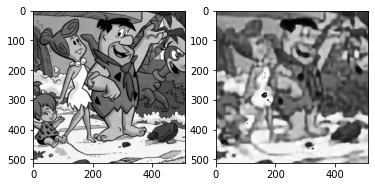

16.64810541680336 0.38501396775245667
Processing  dataSet/Test/Set11_mat/lena256.mat


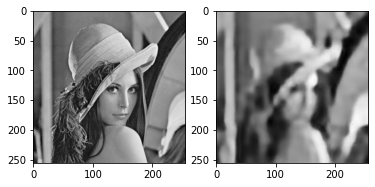

22.15707305973227 0.6053767204284668
Processing  dataSet/Test/Set11_mat/peppers256.mat


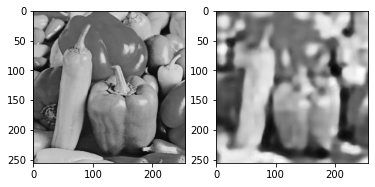

20.77790176193404 0.6254812479019165
Processing  dataSet/Test/Set11_mat/Monarch.mat


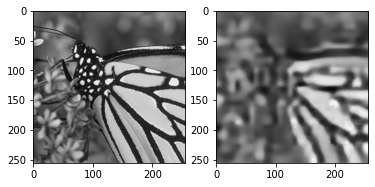

18.01942144612545 0.5119936466217041
Processing  dataSet/Test/Set11_mat/cameraman.mat


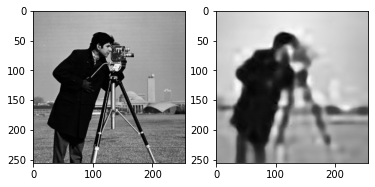

20.411712783313938 0.6198307275772095
Processing  dataSet/Test/Set11_mat/fingerprint.mat


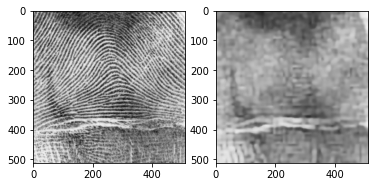

16.21239477338375 0.14871317148208618
Processing  dataSet/Test/Set11_mat/house.mat


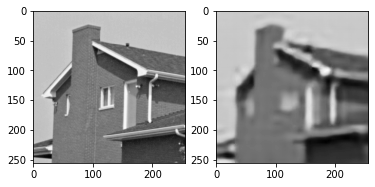

23.62535228219958 0.6701210737228394
Processing  dataSet/Test/Set11_mat/foreman.mat


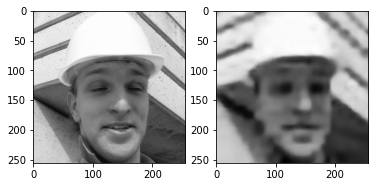

26.484854595910015 0.769482433795929
Processing  dataSet/Test/Set11_mat/Parrots.mat


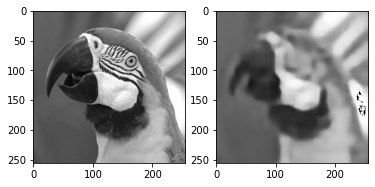

22.275493124981267 0.7206765413284302
Processing  dataSet/Test/Set11_mat/boats.mat


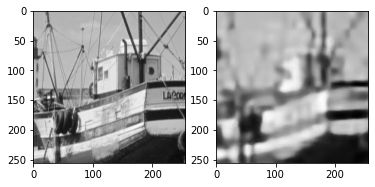

21.96961654380239 0.5399588346481323
Processing  dataSet/Test/Set11_mat/barbara.mat


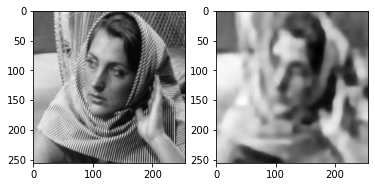

21.698169030477157 0.49801698327064514
Dataset= Set11
PSNR_predicted= 20.934554074423925 0.5540604862299833
It takes average 3.488058393651789s for processing


In [ ]:
import argparse, os
import matplotlib.pyplot as plt
import numpy as np
import time, math, glob
import scipy.io as sio
import cv2
from PIL import Image


def showimg(img, fake_img, subrate=0.1):
    #fake_img = getimg("resImages/babytmpc22hn1_5.png")
    # plt.axis("off")
    # subrate = 0.2
    img = img.convert('L')
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.subplot(1, 2, 2)
    # plt.axis('off')
    plt.imshow(fake_img,cmap='gray')
    # plt.savefig("result_images" + '/butterfly_{}.jpg'.format(subrate), bbox_inches='tight')
    # print("image saved as butterfly_{}.jpg".format(subrate))
    plt.show()


parser = argparse.ArgumentParser(description="PyTorch SRResNet Eval")
parser.add_argument("--cuda", action="store_true", help="use cuda?")
parser.add_argument("--model", default="model/model_srresnet.pth", type=str, help="model path")
parser.add_argument("--dataset", default="Set11", type=str, help="dataset name, Default: Set5")
parser.add_argument("--gpus", default="0", type=str, help="gpu ids (default: 0)")

# def PSNR(pred, gt, shave_border=0):
#     height, width = pred.shape[:2]
#     pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
#     gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
#     imdff = pred - gt
#     rmse = math.sqrt(np.mean(imdff ** 2))
#     if rmse == 0:
#         return 100
#     return 20 * math.log10(255.0 / rmse)

opt = parser.parse_args([])

opt.cuda = False
opt.model =  "/content/checkpoint/model_epoch_798_.pth" #"CSNetPlus_model_t/model_epoch_435_17.98640433730782.pth" #
# opt.model = "CSNetPlus_model_t/0.2_denseBlock3*10.pth"#0.2_888.6.pth"#-1+1_noPurning_depthwise_0.2.pth"  #loss:600
# opt.model = "saved_models/0.1/full_db3_10_28.31.pth"
attention_path = "CSNetPlus_model_mask/0.1_0.0088.pth"

subrate = 0.5

cuda = opt.cuda

if cuda:
    print("=> use gpu id: '{}'".format(opt.gpus))
    os.environ["CUDA_VISIBLE_DEVICES"] = opt.gpus
    if not torch.cuda.is_available():
            raise Exception("No GPU found or Wrong gpu id, please run without --cuda")

model = torch.load(opt.model,)["model"] #map_location=torch.device('cpu')
# mask = atten_cal_mask(atten_matrix=torch.load(attention_path)["atten_matrix"], origin_matrix=model.csPart.sampling.weight, pruning_perc=30)
# print(mask.device)
# model.csPart.sampling.set_mask(mask)
model.eval()
image_list = glob.glob("dataSet/Test/" + opt.dataset + "_mat/*.*") 

avg_psnr_predicted = 0.0
avg_elapsed_time = 0.0
avg_ssim_val = 0.0

pos = 0
for image_name in image_list:
    # pos += 1
    # if pos != 1:
    #     continue
    print("Processing ", image_name)
    im_gt_y = sio.loadmat(image_name)['im_gt_y']

    im_gt_y = im_gt_y.astype(float)
    X = Variable(torch.from_numpy(im_gt_y).float()).view(1, -1, im_gt_y.shape[0], im_gt_y.shape[1])
    im_input = im_gt_y/255.

    im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])


    if cuda:
        model = model.cuda()
        im_input = im_input.cuda()
    else:
        model = model.cpu()

    start_time = time.time()
    res, _ = model(im_input)
    elapsed_time = time.time() - start_time
    avg_elapsed_time += elapsed_time

    from torchvision import transforms

    unloader = transforms.ToPILImage()
    image = res.cpu().clone()  # clone the tensor
    image = image.squeeze(0)  # remove the fake batch dimension
    image = unloader(image)
    showimg(Image.fromarray(im_gt_y), image, subrate)

    res = res.cpu()
    im_res_y = res.data[0].numpy().astype(np.float32)

    im_res_y = im_res_y*255.
    im_res_y[im_res_y<0] = 0
    im_res_y[im_res_y>255.] = 255. 
    im_res_y = im_res_y[0,:,:]
    Y = res*255.
    Y[Y<0] = 0
    Y[Y>255.] = 255

    psnr_predicted = PSNR(im_gt_y, im_res_y,shave_border=0)
    ssim_val = ssim( X, Y, data_range=255, size_average=True) # return (N,)
    # ms_ssim_val = ms_ssim( X, Y, data_range=255, size_average=False ) #(N,)
    # print(ssim_val.item())
    
    print( + psnr_predicted, + ssim_val.item())
    avg_psnr_predicted += psnr_predicted
    avg_ssim_val += ssim_val.item()



print("Dataset=", opt.dataset)
print("PSNR_predicted=", avg_psnr_predicted/len(image_list), avg_ssim_val/len(image_list))
print("It takes average {}s for processing".format(avg_elapsed_time/len(image_list)))

In [ ]:

parm={}
for name,parameters in model.named_parameters():
    print(name,':',parameters.size())
    parm[name]=parameters.detach().cpu().numpy()

In [ ]:
model.csPart.gamma

Parameter containing:
tensor([-0.1817], device='cuda:0', requires_grad=True)

In [ ]:
!cp "/content/checkpoint/model_epoch_464_.pth" "./saved_models/0.2/rgb_full_db3_10.pth"

In [ ]:
import math
import time
from os import listdir
from os.path import join
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_msssim import ssim
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, \
    ToTensor, Resize, Grayscale

# from modules import *


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', 'bmp', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def showimg(img, fake_img, subrate=0.1):
    # fake_img = getimg("resImages/babytmpc22hn1_5.png")
    # plt.axis("off")
    # subrate = 0.2
    # img = img.convert('L')
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.subplot(1, 2, 2)
    # plt.axis('off')
    plt.imshow(fake_img, )
    # plt.imshow(fake_img, cmap='gray')
    # plt.savefig("result_images" + '/butterfly_{}.jpg'.format(subrate), bbox_inches='tight')
    # print("image saved as butterfly_{}.jpg".format(subrate))
    plt.show()


class test_dataset_for_folder(Dataset):
    def __init__(self, dataset_dir, crop_size=256):
        super(test_dataset_for_folder, self).__init__()
        # self.blocksize = blocksize
        self.high_res_length = crop_size
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        self.test_compose = Compose([
            # CenterCrop(crop_size),
            # Grayscale(),
            ToTensor(),
            Resize((crop_size,crop_size)),
            # transforms.Normalize(mean=0.5, std=0.5)
        ])

    def __getitem__(self, index):
        hr_image = Image.open(self.image_filenames[index])

        hr_image = self.test_compose(hr_image)

        return hr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)


def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

def up2ssim255(y):
    y = y * 255.
    y[y < 0] = 0
    y[y > 255.] = 255
    return y

def image_in_model_test(data_path, model_path, crop_size=256, cuda=False, ):
    image_filenames = [join(data_path, x) for x in listdir(data_path) if is_image_file(x)]
    test_compose = Compose([
        # CenterCrop(crop_size),
        # Grayscale(),
        Resize((crop_size, crop_size)),
        ToTensor(),
        # transforms.Normalize(mean=0.5, std=0.5)
    ])

    model = torch.load(model_path, map_location=torch.device('cpu'))["model"]  #
    if cuda:
        model = model.cuda()
    else:
        model = model.cpu()
    model.eval()
    #  print(low_res_sample.size(0))
    total_elapsed_time = 0
    avg_psnr_predicted = 0
    avg_ssim_val = 0
    for image_name in image_filenames:
        origin_image = Image.open(image_name)
        origin_image_tensor = test_compose(origin_image)
        x = origin_image_tensor.view(1, -1, origin_image_tensor.shape[1], origin_image_tensor.shape[2])
        if cuda:
            x = x.cuda()

        start_time = time.time()
        fake_image, _ = model(x)
        elapsed_time = time.time() - start_time
        total_elapsed_time += elapsed_time

        from torchvision import transforms

        unloader = transforms.ToPILImage()
        output_image = fake_image.cpu().clone()  # clone the tensor
        output_image = output_image.squeeze(0)  # remove the fake batch dimension
        output_image = unloader(output_image)
        origin_image_gray = unloader(origin_image_tensor)
        # a,b = np.array(input_image),np.array(output_image)
        showimg(origin_image_gray, output_image, 1)
        X = x.cpu()
        X = up2ssim255(X)
        Y = fake_image.cpu()
        Y = up2ssim255(Y)

        psnr_predicted = PSNR(np.array(origin_image_gray), np.array(output_image), shave_border=0)
        ssim_val = ssim(X, Y, data_range=255, size_average=True)  # return (N,)
        # ms_ssim_val = ms_ssim( X, Y, data_range=255, size_average=False ) #(N,)
        # print(ssim_val.item())

        print(+ psnr_predicted, + ssim_val.item())
        avg_psnr_predicted += psnr_predicted
        avg_ssim_val += ssim_val.item()

    print("Dataset=", data_path)
    print("PSNR_predicted=", avg_psnr_predicted / len(image_filenames), avg_ssim_val / len(image_filenames))
    print("It takes {}s for processing".format(total_elapsed_time / len(image_filenames)))



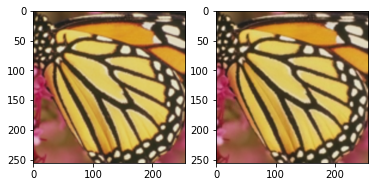

38.29300883644115 0.9850824475288391


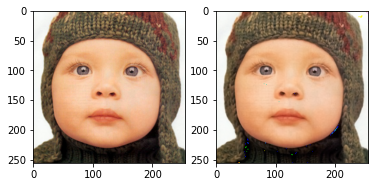

36.4691433957238 0.9594140648841858


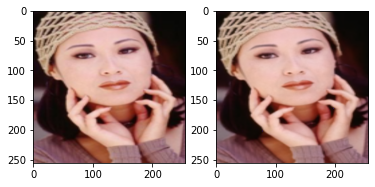

41.227099451351066 0.9896014332771301


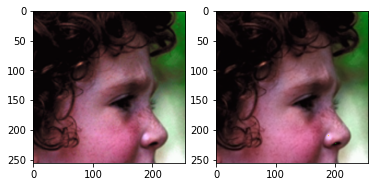

41.89788261297247 0.9817846417427063


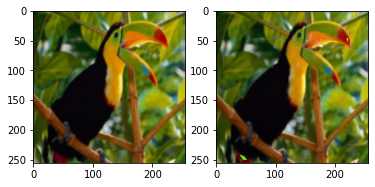

35.64410104567942 0.9480946660041809
Dataset= /content/gdrive/MyDrive/Colab Notebooks/dataSet/Test/Set5
PSNR_predicted= 38.70624706843358 0.9727954506874085
It takes 2.4336861610412597s for processing


In [ ]:
image_in_model_test(
    data_path='/content/gdrive/MyDrive/Colab Notebooks/dataSet/Test/Set5', 
    # model_path="/content/gdrive/MyDrive/Colab Notebooks/saved_models/0.1/full_db3_10_28.31.pth",
    # model_path="/content/gdrive/MyDrive/Colab Notebooks/CSNetPlus_model_t/rgb_full_0.2_800_.pth",
    model_path="/content/checkpoint/model_epoch_798_.pth",
    cuda=False,
    )